# Решающее дерево для предсказания погиб пассажир или нет по Dataset Titanic

In [87]:
# Импортируем необходимые библиотеки
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import tree 
%matplotlib inline 

In [21]:
!pip install graphviz 
from IPython.display import SVG 
from graphviz import Source 
from IPython.display import display 

from IPython.display import HTML 
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>" 
HTML(style) 

In [22]:
titanic_data = pd.read_csv('train.csv') 

In [23]:
titanic_data.head() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
# Посмотрим на полученные данные
titanic_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
# Посмотрим на количество пропущенных значений
titanic_data.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Выберем в переменную X только нужные колонки, удалив ненужные**

In [26]:
X = titanic_data.drop(['PassengerId','Survived','Name','Ticket','Cabin'], axis=1) 
y = titanic_data.Survived 

In [27]:
X.head() 

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


Дерево решений работает только с числовыми переменными, поэтому заменим строковые переменные на числовые: 

In [28]:
# Используем функцию get_dummies
X = pd.get_dummies(X) 
X.head() 

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Также алгоритм дерева решений не может работать с пустыми значениями

In [29]:
# Заменим пустые значения столбца Age на средний возраст в зависимости от класса каюты 
age_1 = titanic_data.loc[titanic_data['Pclass'] == 1]['Age'].mean() 
age_2 = titanic_data.loc[titanic_data['Pclass'] == 2]['Age'].mean() 
age_3 = titanic_data.loc[titanic_data['Pclass'] == 3]['Age'].mean() 

# напишем необходимую функцию по выбору среднего возраста для заполнения пустых ячеек
def fill_age(row): 
    if pd.isnull(row['Age']): 
        if row['Pclass'] == 1: 
            return age_1 
        if row['Pclass'] == 2: 
            return age_2 
        return age_3 
    return row['Age'] 

X['Age'] = X.apply(fill_age, axis=1) 

In [30]:
# Убедимся в том, что нет пропущенных значений
X.isnull().sum() 

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [34]:
# Создадим новый признак по количеству родственников, совместно ехавших в каютах
X['alone'] = X.apply(lambda row: 1 if row['SibSp']+row['Parch'] > 0 else 0, axis=1) 

In [35]:
# Создадим классификатор
clf = tree.DecisionTreeClassifier(criterion='entropy') 

In [36]:
# Обучим дерево
clf.fit(X, y) 

DecisionTreeClassifier(criterion='entropy')

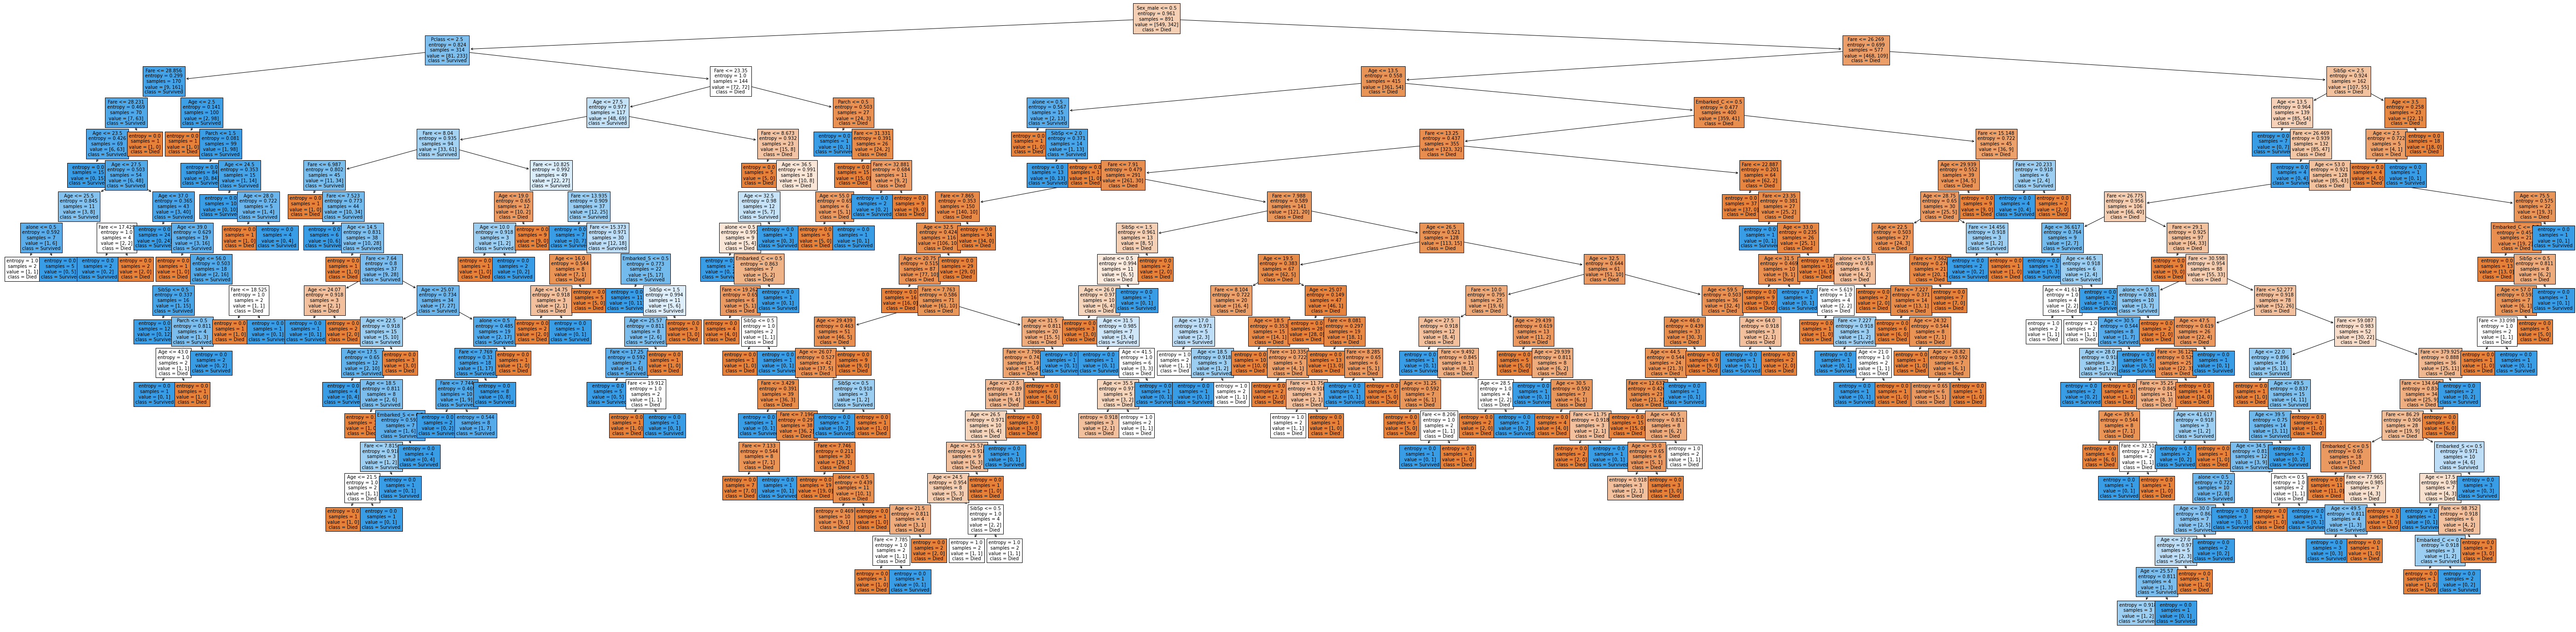

In [42]:
plt.figure(figsize=(100, 25)) 
tree.plot_tree(clf, fontsize=10, feature_names=list(X), class_names=['Died', 'Survived'], filled=True); 

***Дерево получилось очень глубоким, попробуем его уменьшить без существенной потери качества предсказания***

In [43]:
# Создадим тестовые и обучающие выборки из наших данных 
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) 

In [44]:
# Посмотрим на размер полученных выборок
X_train.shape

(596, 11)

In [45]:
X_test.shape

(295, 11)

In [46]:
# Посмотрим на долю правильных ответов исходного дерева
clf.score(X, y) 

0.9820426487093153

In [47]:
# Обучим дерево на обучающей выборке
clf1 = tree.DecisionTreeClassifier(criterion='entropy') 
clf1.fit(X_train, y_train) 

DecisionTreeClassifier(criterion='entropy')

In [48]:
# Посмотрим на долю правильных ответов дерева по выборке
clf1.score(X_test, y_test) 

0.7898305084745763

***Ограничим глубину дерева до 3 и посмотрим на эффективность его работы***

In [49]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3) 

In [50]:
# Обучим на обучающей выборке
clf.fit(X_train, y_train) 

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [51]:
# Посмотрим на долю правильных предсказаний
clf.score(X_train, y_train) 

0.8238255033557047

In [52]:
# Посмотрим на долю правильных предсказаний по тестовой выборке
clf.score(X_test, y_test) 

0.8203389830508474

Отсюда вывод, что дерево стало лучше предсказывать, в отличие от дерева, которое никак не ограничивали (**82% против 79%**)

Попробуем подобрать параметр глубины дерева

In [57]:
max_depth_values = range(1, 100) 

In [58]:
scores_data = pd.DataFrame() 

In [59]:
for max_depth in max_depth_values: 
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth) 
    clf.fit(X_train, y_train) 
    train_score = clf.score(X_train, y_train) 
    test_score = clf.score(X_test, y_test) 
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score], 
                                    'test_score': [test_score]}) 
    scores_data = scores_data.append(temp_score_data) 

In [60]:
# Посмотрим что получили
scores_data.head() 

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.842282,0.813559


In [61]:
# Сделаем группировку score в один столбец и добавим столбец с типом
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                          var_name='set_type', value_name='score') 

In [62]:
scores_data_long.head() 

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.842282


In [63]:
import seaborn 
seaborn.__version__ 

'0.11.0'

<AxesSubplot:xlabel='max_depth', ylabel='score'>

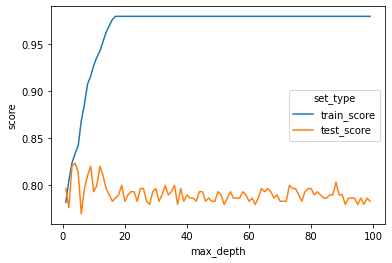

In [64]:
# Нарисуем график с полученными долями
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long) 

### Анализ графика:
с увеличеним глубины дерева растет точность классификации на тренировочной выборке, но это не всегда ведет к нахождению общих закономерностей исследуемых данных
test score изначально невелик(модель ещ ене доучилась), на промежутке 3-5 score максимален(оптимальное состояние: закономерность с изученных данных переносится на новые), но в дальнейшем с увеличеним train score начинает падать test score(переход от недообученности к переобученности)

Проведём обучение на нескольких подвыборках, меняя тестовые и обучающие подвыборки, так, чтобы каждая подвыборка побывала тестовой и обучающей

In [65]:
# Импортируем необходимую библиотеку для кроссвалидаций
from sklearn.model_selection import cross_val_score 

In [66]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4) 

In [67]:
# Разобъём на 5 подвыборок 
cross_val_score(clf, X_train, y_train , cv=5) 

array([0.76666667, 0.82352941, 0.78991597, 0.75630252, 0.80672269])

In [68]:
# Возьмем среднюю точность 
cross_val_score(clf, X_train, y_train , cv=5).mean() 

0.7886274509803922

In [69]:
scores_data = pd.DataFrame() 

In [70]:
# Переопределяем нашу кроссвалидацию 
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train , cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data) 

In [71]:
scores_data.head() 

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.842282,0.810169,0.793669


In [72]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
                          var_name='set_type', value_name='score') 

In [73]:
scores_data_long.head() 

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.842282


<AxesSubplot:xlabel='max_depth', ylabel='score'>

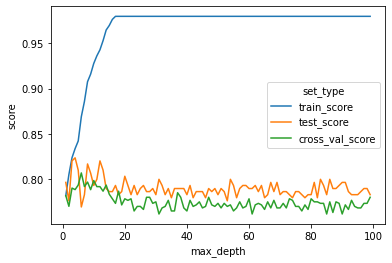

In [74]:
# Посмотрим на наш новый график 
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long) 

Из графика видно, что максимальная точность достигается при большей глубине дерева, чем 3-5

cross_val_score более устойчив к переобучению

найдем дерево с максимальным значением cross_val_score

In [75]:
# Посмотрим на доли подвыборок, где cross_val_score
scores_data_long.query("set_type == 'cross_val_score'").head(20) 

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.793669
203,6,cross_val_score,0.807059
204,7,cross_val_score,0.791975
205,8,cross_val_score,0.796989
206,9,cross_val_score,0.788571
207,10,cross_val_score,0.798641


In [81]:
max_cross = scores_data_long.query("set_type == 'cross_val_score'").max()[2] 

In [84]:
scores_data_long.loc[(scores_data_long.set_type == 'cross_val_score') & (scores_data_long.score == max_cross)] 

,max_depth,set_type,score
203,6,cross_val_score,0.807059


Видно, что при глубине дерева равной 6 достигается максимальный score

In [85]:
# Обозначим лучшее дерево с глубиной равной 6: 
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6) 

In [86]:
cross_val_score(best_clf, X_test, y_test , cv=5).mean() 

0.8067796610169491

Получили финальную точность предсказания нашей модели **0.807** 